# Creating timeseries of the GOES data for 8 speakers

- 8 channels (need 8 timeseries)
- 12 minute piece, GOES samples every 5-minutes

The artist wanted a viewer to feel like weather was moving through the room. 

This means we must think about time and space.

Space:
So, the 8 speakers should correspond to 8 different locations around the viewer. The spatial scale of the data variablity will need to be explored so we can determine the right distance these locations should be. Maybe if they are only 1 km apart, there isn't enough of a 'difference' for the sound to feel immersive.  But if the locations are too far apart, then they won't be correlated to eachother and may just sound like 8 unconnected sounds.

Time: 
GOES CONUS data has 5-minute sampling. 
The piece is 12 minutes long - so if we went with realtime data, we would have 2 data points that could be interpolated together,
but basically two gradient tones during 12 minutes is not very dynamic, 
but that might be okay? The other issues is that I think this surface data is meant to be dominate during only the first 3 minutes,
so maybe we are only really looking at 3 minutes of gradients. If that is the case, in order to get a sense of weather, 
it might be necessary to create a compressed timeseries of data over the last hour or so.

GOES:

GOES has full disk, CONUS, mesoscale options as well as many different products.
I'm using CONUS below as it has high spatial resolution, 5-minute sampling.

## Steps in code below:
- The code looks at two different GOES datasets. We don't really want one with cloud masks (missing data). 
- Georeference the coordinate system so we can look up data around a latitude and longitude
- Calculate 8 points near a reference location (Miami)
- Create timeseries of data at those points 

In [1]:
from goes2go import GOES
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#list of GOES products https://github.com/blaylockbk/goes2go/blob/main/goes2go/product_table.txt

# Calculate latitude and longitude from GOES ABI fixed grid projection data
#GOES ABI fixed grid projection is a map projection relative to the GOES satellite  
#Units: latitude in °N (°S < 0), longitude in °E (°W < 0)  
#See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations  
#"file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library  
#code from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php  
#Acknowledgement:  NOAA/NESDIS/STAR Aerosols and Atmospheric Composition Science Team  
#Their code is written for numpy arrays not xarray, so I updated it to work with xarray datasets  

# Target latitude and longitude MIAMI
target_lat = 25.76  # Example: Latitude of Miami
target_lon = -80.19  # Example: Longitude of Miami

def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.attrs.get('longitude_of_projection_origin')
    H = projection_info.attrs.get('perspective_point_height')+projection_info.attrs.get('semi_major_axis')
    r_eq = projection_info.attrs.get('semi_major_axis')
    r_pol = projection_info.attrs.get('semi_minor_axis')
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

def forward_fill_2d(arr):
    # Loop through each column
    for i in range(arr.shape[1]):
        mask = np.isnan(arr[:, i])
        # Forward fill NaN values
        arr[mask, i] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), arr[~mask, i])
    return arr

def find_nearest_indices(lat_arr, lon_arr, target_lat, target_lon):
    # Find the nearest latitude index
    lat_idx = (np.abs(lat_arr - target_lat)).argmin()
    # Find the nearest longitude index
    lon_idx = (np.abs(lon_arr - target_lon)).argmin()
    return lat_idx, lon_idx


C:\Users\clwhit13\AppData\Local\miniconda3\envs\heart\Lib\site-packages\goes2go\data.py:665: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
C:\Users\clwhit13\AppData\Local\miniconda3\envs\heart\Lib\site-packages\goes2go\NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


# lets look at GOES TPWC data and see what it looks like

In [2]:
G = GOES(satellite=16, product="ABI-L2-TPWC", domain='C')
# Download and read the data as an xarray Dataset nearest a specific time
ds = G.nearesttime('2024-06-29')
abi_lat, abi_lon = calculate_degrees(ds)
abi_lat = forward_fill_2d(abi_lat.copy())
abi_lon = forward_fill_2d(abi_lon.copy())

 👮🏻‍♂️ File already exists. Do not overwrite: C:\Users\clwhit13\data\noaa-goes16\ABI-L2-TPWC\2024\181\00\OR_ABI-L2-TPWC-M6_G16_s20241810001177_e20241810003550_c20241810005237.nc
📦 Finished downloading [1] files to [C:\Users\clwhit13\data\noaa-goes16\ABI-L2-TPWC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

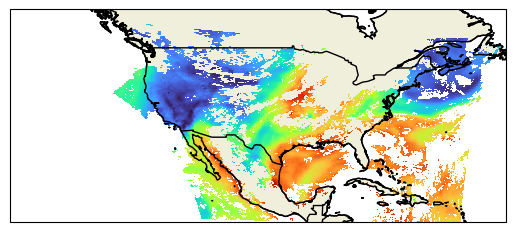

In [3]:
# Create a plot using pcolormesh
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(abi_lon,abi_lat, ds.TPW, transform=ccrs.PlateCarree(), cmap='turbo')

# Add the coastlines or continents
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Look at other data

That has missing data and would be hard to sonify the missing data

Let's look at the cloud and moisture data

📦 Finished downloading [1] files to [C:\Users\clwhit13\data\noaa-goes16\ABI-L2-MCMIPC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

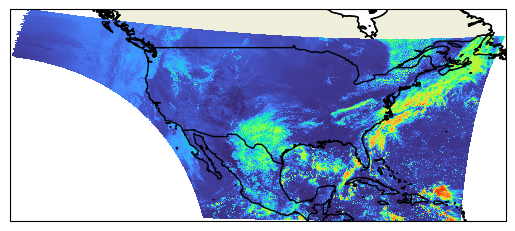

In [4]:
# Open the GOES-R image
G = GOES(satellite=16, product="ABI-L2-MCMIPC", domain='C')
# Download and read the latest data as an xarray Dataset
ds = G.latest()
abi_lat, abi_lon = calculate_degrees(ds)
abi_lat = forward_fill_2d(abi_lat.copy())
abi_lon = forward_fill_2d(abi_lon.copy())

# Create a plot using pcolormesh
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(abi_lon,abi_lat, ds.CMI_C01, transform=ccrs.PlateCarree(), cmap='turbo')

# Add the coastlines or continents
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

# Georeference the GOES coordinates

In [5]:
#note this isn't going to be perfect because used 1d so run one time, then again with closer values
# Find nearest indices
lat_idx, lon_idx = find_nearest_indices(abi_lat[:,0], abi_lon[0,:], target_lat, target_lon)
print('first guess i,j',lat_idx,lon_idx)
lat_idx, lon_idx = find_nearest_indices(abi_lat[:,lon_idx], abi_lon[lat_idx,:], target_lat, target_lon)
print('closer guess i,j',lat_idx,lon_idx)
print(abi_lat[lat_idx,lon_idx],abi_lon[lat_idx,lon_idx])

first guess i,j 994 1640
closer guess i,j 941 1553
25.78001813579365 -80.24116009542536


In [6]:
#test out different distances for the 8 points we will feed to different channels
istep = 1 
value = 111*np.abs(abi_lat[lat_idx,lon_idx]-abi_lat[lat_idx+istep,lon_idx])*np.sin(25.78*np.pi/180.)
print('spatial difference between points (lat):', f"{value:.1f}", 'km')
value = 111*np.abs(abi_lon[lat_idx,lon_idx]-abi_lon[lat_idx,lon_idx+istep])*np.sin(25.78*np.pi/180.)
print('spatial difference between points (lon):', f"{value:.1f}", 'km')
north_point = [lat_idx+istep,lon_idx]
east_point = [lat_idx,lon_idx+istep]
south_point = [lat_idx-istep,lon_idx]
west_point = [lat_idx,lon_idx-istep]
northeast_point = [lat_idx+istep,lon_idx+istep]
northwest_point = [lat_idx+istep,lon_idx-istep]
southeast_point = [lat_idx-istep,lon_idx+istep]
southwest_point = [lat_idx-istep,lon_idx-istep]
data_points = [north_point,east_point,south_point,west_point,northeast_point,northwest_point,southeast_point,southwest_point]

spatial difference between points (lat): 1.0 km
spatial difference between points (lon): 1.0 km


# now we have some data points, we need to create a timeseries of data

goes2go downloads the data before reading it  
since we are looking at timeseries and there are like 288 files each day (5 min data)  
i don't want to download all that data  
so i'm trying to figure out if I can lazy load it  


In [130]:
now = datetime.now()
now_string = now.strftime("%Y-%m-%d %H:%M")
yesterday = now - timedelta(hours=1)
yesterday_string = yesterday.strftime("%Y-%m-%d %H:%M")
# Open the GOES-R image
G = GOES(satellite=16, product="ABI-L2-MCMIPC", domain='C')
# Produce a pandas DataFrame of the available files in a time range
df = G.df(start=yesterday_string, end=now_string)
df.file[0]

'noaa-goes16/ABI-L2-MCMIPC/2024/247/15/OR_ABI-L2-MCMIPC-M6_G16_s20242471556170_e20242471558549_c20242471559083.nc'

In [29]:
import s3fs
import xarray as xr

fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!
  
#use glob to list all the files in the directory
#file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
file_location=df.file

#make a list of links to the file keys
#if len(file_location)<1:
#    return file_ob
file_ob = [fs.open('s3://'+file) for file in file_location]        #open connection to files
    
#open all the day's data
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
ds

<xarray.Dataset> Size: 6GB
Dimensions:                                 (time: 12, y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       (time) datetime64[ns] 96B 2024-09...
  * y                                       (y) float32 6kB 0.1282 ... 0.04427
  * x                                       (x) float32 10kB -0.1013 ... 0.03861
    y_image                                 float32 4B 0.08624
    x_image                                 float32 4B -0.03136
    band_wavelength_C01                     (band) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
    band_id_C11                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C12                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C13                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C14                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C15                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C16                             (band) int8 1B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: time, number_of_time_bounds,
                                number_of_image_bounds, band
Data variables: (12/124)
    CMI_C01                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    DQF_C01                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    CMI_C02                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    DQF_C02                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    CMI_C03                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    DQF_C03                                 (time, y, x) float32 180MB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    ...                                      ...
    mean_brightness_temperature_C16         (time) float32 48B 262.7 ... 262.8
    std_dev_brightness_temperature_C16      (time) float32 48B 15.03 ... 15.17
    percent_uncorrectable_GRB_errors        (time) float32 48B 0.0 0.0 ... 0.0
    percent_uncorrectable_L0_errors         (time) float32 48B 0.0 0.0 ... 0.0
    dynamic_algorithm_input_data_container  (time) int32 48B -2147483647 ... ...
    algorithm_product_version_container     (time) int32 48B -2147483647 ... ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2024-09-02T12:54:07.7Z
    time_coverage_start:       2024-09-02T12:51:17.0Z
    time_coverage_end:         2024-09-02T12:53:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        c24f22c1-fcc4-41d4-8d0b-ac46a7b810e6

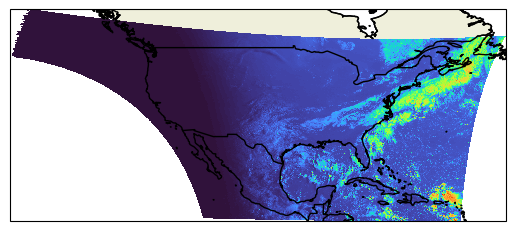

In [33]:
ds2 = ds.isel(time=0)
abi_lat, abi_lon = calculate_degrees(ds2)
abi_lat = forward_fill_2d(abi_lat.copy())
abi_lon = forward_fill_2d(abi_lon.copy())

# Create a plot using pcolormesh
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(abi_lon,abi_lat, ds2.CMI_C01, transform=ccrs.PlateCarree(), cmap='turbo')

# Add the coastlines or continents
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')

In [126]:
#how big do we want to have the box?
#istep is how many grid points away from the center that we want to go

istep = 1

# List of points you want to subset around point x
#   *  *  *
#   *  x  *
#   *  *  *
#north_point = [lat_idx+istep,lon_idx]
#east_point = [lat_idx,lon_idx+istep]
#south_point = [lat_idx-istep,lon_idx]
#west_point = [lat_idx,lon_idx-istep]
#northeast_point = [lat_idx+istep,lon_idx+istep]
#northwest_point = [lat_idx+istep,lon_idx-istep]
#southeast_point = [lat_idx-istep,lon_idx+istep]
#southwest_point = [lat_idx-istep,lon_idx-istep]

points = [
    {"i": int(lon_idx)+istep, "j": int(lat_idx)+istep, "name": 'NE'},
    {"i": int(lon_idx)+istep, "j": int(lat_idx), "name": 'East'},
    {"i": int(lon_idx)+istep, "j": int(lat_idx)-istep, "name": 'SW'},
    {"i": int(lon_idx), "j": int(lat_idx)+istep, "name": 'N'},
    {"i": int(lon_idx), "j": int(lat_idx)-istep, "name": 'S'},
    {"i": int(lon_idx)-istep, "j": int(lat_idx)+istep, "name": 'NW'},
    {"i": int(lon_idx)-istep, "j": int(lat_idx), "name": 'W'},
    {"i": int(lon_idx)-istep, "j": int(lat_idx)-istep, "name": 'SW'},
]

In [129]:
# print out lat/lon of points
#print(abi_lat.shape)
#for p in range(len(points)):
#    print(abi_lat[points[p].get('j'),points[p].get('i')],abi_lon[points[p].get('j'),points[p].get('i')])

In [107]:
# Subsetting the dataset to the points
#print(points[0].get('j'),points[0].get('i'))
combined_data=ds.isel(y=points[0].get('j'), x=points[0].get('i')) #, method="nearest")
for p in range(len(points)):
    if p>0:
        #print(points[p].get('j'),points[p].get('i'))
        tem=ds.isel(y=points[p].get('j'), x=points[p].get('i')) #, method="nearest")
        combined_data = xr.concat([combined_data, tem], dim="points_index")
subset=combined_data.load() #now load the little baby dataset

942 1554
941 1554
940 1554
942 1553
940 1553
942 1552
941 1552
940 1552


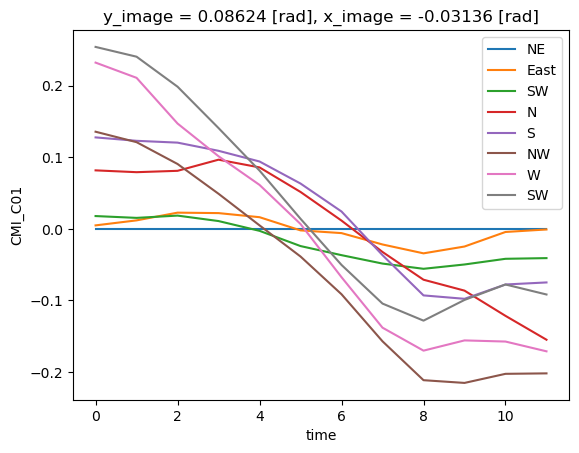

In [128]:
fig, ax = plt.subplots()
for i in range(8):
    (subset.CMI_C01[i,:]-subset.CMI_C01[0,:]).plot(ax=ax, label=points[i].get('name'))
ax.legend()

<xarray.Dataset> Size: 56kB
Dimensions:                                 (points_index: 8, time: 12,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       (time) datetime64[ns] 96B 2024-09...
    y                                       (points_index) float32 32B 0.0754...
    x                                       (points_index) float32 32B -0.014...
    y_image                                 float32 4B 0.08624
    x_image                                 float32 4B -0.03136
    band_wavelength_C01                     (band) float32 4B 0.47
    ...                                      ...
    band_id_C11                             (band) int8 1B 11
    band_id_C12                             (band) int8 1B 12
    band_id_C13                             (band) int8 1B 13
    band_id_C14                             (band) int8 1B 14
    band_id_C15                             (band) int8 1B 15
    band_id_C16                             (band) int8 1B 16
Dimensions without coordinates: points_index, time, number_of_time_bounds,
                                number_of_image_bounds, band
Data variables: (12/124)
    CMI_C01                                 (points_index, time) float32 384B ...
    DQF_C01                                 (points_index, time) float32 384B ...
    CMI_C02                                 (points_index, time) float32 384B ...
    DQF_C02                                 (points_index, time) float32 384B ...
    CMI_C03                                 (points_index, time) float32 384B ...
    DQF_C03                                 (points_index, time) float32 384B ...
    ...                                      ...
    mean_brightness_temperature_C16         (points_index, time) float32 384B ...
    std_dev_brightness_temperature_C16      (points_index, time) float32 384B ...
    percent_uncorrectable_GRB_errors        (points_index, time) float32 384B ...
    percent_uncorrectable_L0_errors         (points_index, time) float32 384B ...
    dynamic_algorithm_input_data_container  (points_index, time) int32 384B -...
    algorithm_product_version_container     (points_index, time) int32 384B -...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2024-09-02T12:54:07.7Z
    time_coverage_start:       2024-09-02T12:51:17.0Z
    time_coverage_end:         2024-09-02T12:53:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        c24f22c1-fcc4-41d4-8d0b-ac46a7b810e6